In [734]:
from datetime import datetime, timedelta
import pandas as pd
import pandas
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy.fftpack import fft
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn import preprocessing

In [735]:
# To get all the files from local directory
numFiles = 5
cgm_values = [pd.read_csv('dm_proj1_data/CGMSeriesLunchPat{}.csv'.format(i)) for i in range(1, numFiles + 1)]
cgm_timestamps = [pd.read_csv('dm_proj1_data/CGMDatenumLunchPat{}.csv'.format(i)) for i in range(1, numFiles + 1)]

In [736]:
# To change date from Epoch to Standard Time
def mdate_to_pdate(mdate):
    return (datetime.fromordinal(int(mdate)) + timedelta(days=mdate % 1) - timedelta(days=366)).strftime("%Y-%m-%d %H:%M:%S")

In [737]:
# print('first', mdate_to_pdate(737225.5842))
# print('last', mdate_to_pdate(737225.48))

In [738]:
# To apply Epoch to Standard Time function to all every column in Date DataFrame
def epochToDate(cgmT):
    for col in cgmT.columns:
        cgmT[col] = cgmT[col].apply(lambda x: mdate_to_pdate(x) if pd.notnull(x) else x)

for i in range(numFiles):
    epochToDate(cgm_timestamps[i])

In [739]:
for i in range(numFiles):
    cgm_timestamps[i], cgm_values[i] = cgm_timestamps[i].T, cgm_values[i].T

In [740]:
# Adding index name for each row
for i in range(numFiles):
    cgm_timestamps[i] = cgm_timestamps[i].set_index([pandas.Index(['cgm_{}'.format(i) for i in range(1, len(cgm_timestamps[i]) + 1)])])
    cgm_values[i] = cgm_values[i].set_index([pandas.Index(['cgm_{}'.format(i) for i in range(1, len(cgm_timestamps[i]) + 1)])])

In [741]:
cgm_merged = []
for i in range(numFiles):
    cgm_merged.append(pandas.merge(cgm_timestamps[i], cgm_values[i], how="inner", left_index=True, right_index=True))

In [742]:
# To get columns name to get CGM and Date side by side for every 2.5 hour slot
def colNames(cgmM):
    cols = cgmM.columns.tolist()
    new_cols = []
    for i in range(len(cols) // 2):
        new_cols.extend([cols[i], cols[len(cols) // 2 + i]])
    return new_cols


cols = []
for i in range(numFiles):
    cols.append(colNames(cgm_merged[i]))

In [743]:
for i in range(numFiles):
    cgm_merged[i] = cgm_merged[i][cols[i]]
    cgm_merged[i] = cgm_merged[i].fillna(method='ffill', limit=2)

In [744]:
# sort timeseries
for j in range(numFiles):
    for i in cgm_merged[j].columns:
        cgm_merged[j][i] = cgm_merged[j][i].values[::-1]

In [745]:
# for i in range(1, numFiles + 1):
#     cgm_merged.to_csv("dm_proj1_data/intermediate_files/cgm_merged_{}.csv".format(i))

In [746]:
# To See Graph plots for time series
# used for analysis purpose only

# cgmM = cgm_merged[0]
# for cgmM in cgm_merged:
#     for i in range(len(cgmM)):
#         x, y = str(i) + "_x", str(i) + "_y"
#         plt.plot(cgmM[x], cgmM[y])
#         plt.title("Patient: 1 Meal #{}".format(x.split("_")[0]))
#         plt.xticks(rotation=90)
#         plt.savefig("Meal_{}.png".format(x.split("_")[0]))
#         plt.close()


In [747]:
# To skip columns with majority of NaN values
skipCols=[]
for idx in range(numFiles):
    delCol = []
    for i in range(len(cgm_merged[idx]) // 2):
        x, y = '{}_x'.format(i), '{}_y'.format(i)
        if sum(pd.isnull(cgm_merged[idx][y])) >= len(cgm_merged[idx][y]) // 2:
            delCol.append(i)
    skipCols.append({} if not delCol else {j:None for j in delCol})
# print(skipCols)
def checkNaN(skipCols,idx,i):
    return False if not skipCols[idx] else True if skipCols[idx].__contains__(i) else False

# checkNaN(skipCols,2,9)

In [748]:
# Feature 1 (Part 1) OutOfRange
def addOutofRange(cgmMO):
    num = 2
    for i in range(len(cgmMO.columns) // 2):
        cgmMO.insert(num, '{}_out_of_range'.format(i), [70 - j if j < 70 else j - 180 if j > 180 else 0 for j in cgmMO['{}_y'.format(i)]], True)
        num += 3


def delOutOfRange(cgmMO):
    out = []
    for i in range(len(cgmMO.columns) // 3):
        out.append(round(sum(cgmMO['{}_out_of_range'.format(i)]) / len(cgmMO['{}_out_of_range'.format(i)]), 2))
        del cgmMO['{}_out_of_range'.format(i)]
    return out


for i in range(numFiles):
    addOutofRange(cgm_merged[i])


In [749]:
# Feature 1 (Part 2) OutOfRange
def countOutOfRange(cgmMO):
    posCount, negCount = 0, 0
    outOfRange = []
    for i in range(len(cgmMO.columns) // 3):
        for j in cgmMO['{}_out_of_range'.format(i)]:
            if j > 0:
                posCount += 1
            if j < 0:
                negCount += 1
    #     outOfRange.append([posCount,negCount])
        outOfRange.append(posCount)
        posCount, negCount = 0, 0
    return outOfRange


outOfRangeList = []
for i in range(numFiles):
    outOfRangeList.append([countOutOfRange(cgm_merged[i]), delOutOfRange(cgm_merged[i])])

In [750]:
# creating Feature Matrix and adding Out of Range feature in it
timeRange = [
    [
        '{1} - {0}'.format(cgm_merged[idx]['{}_x'.format(i)][0], cgm_merged[idx]['{}_x'.format(i)][-1]) for i in range(len(cgm_merged[idx].columns) // 2)
    ] for idx in range(numFiles)
]

feature_matrix = [pd.DataFrame({'timeRange': timeRange[i], 'OutOfRange': outOfRangeList[i][0], 'meanOutOfRange':outOfRangeList[i][1]}) for i in range(numFiles)]

In [751]:
# Feature 2 Mann-Kendall Test statistics
def mk_test(DF, alpha=0.3):
    """
    Input:
        DF:   a vector of data
        alpha: significance level (0.05 default)

    Output:
        trend: tells the trend (increasing, decreasing or no trend)
        h: True (if trend is present) or False (if trend is absence)
        p: p value of the significance test
        z: normalized test statistics

    Examples
    --------
      >>> DF = np.random.rand(100)
      >>> trend,h,p,z = mk_test(DF,0.05)
    """

    n = len(DF)

    # calculate S
    s = 0
    for k in range(n - 1):
        for j in range(k + 1, n):
            s += np.sign(DF[j] - DF[k])

    # calculate the unique data
    unique_x = np.unique(DF)
    g = len(unique_x)

    # calculate the var(s)
    if n == g:  # there is no tie
        var_s = (n * (n - 1) * (2 * n + 5)) / 18
    else:  # there are some ties in data
        tp = np.zeros(unique_x.shape)
        for i in range(len(unique_x)):
            tp[i] = np.sum(DF == unique_x[i])
        var_s = (n * (n - 1) * (2 * n + 5) - np.sum(tp * (tp - 1) * (2 * tp + 5))) / 18

    if s > 0:
        z = (s - 1) / np.sqrt(var_s)
    elif s < 0:
        z = (s + 1) / np.sqrt(var_s)
    else:  # s == 0:
        z = 0

    # calculate the p_value
    p = 2 * (1 - norm.cdf(abs(z)))  # two tail test
    h = abs(z) > norm.ppf(1 - alpha / 2)

    trend = -1 if z < 0 and h else 1 if z > 0 and h else 0

    return trend, h, p, z

In [752]:
# Feature 2 Testing phase
# for j in range(numFiles):
#     for i in range(len(cgm_merged[j].columns) // 2):
#         col = str(i) + '_y'
#         print("Meal #{} :{}".format(i, mk_test(cgm_merged[j][col].values.ravel())))

In [753]:
# Adding Feature 2 in Feature Matrix
for idx in range(numFiles):
    # Insert mk_testt_trend
    feature_matrix[idx].insert(3, "mk_test_trend", [mk_test(cgm_merged[idx][str(i) + '_y'].values.ravel())[0] for i in range(len(cgm_merged[idx].columns) // 2)])

    # Insert mk_test_p_value: p value of the significance test
    feature_matrix[idx].insert(4, "mk_test_p_value", [mk_test(cgm_merged[idx][str(i) + '_y'].values.ravel())[2] for i in range(len(cgm_merged[idx].columns) // 2)])

    # Insert mk_test_z_value: normalized test statistics
    feature_matrix[idx].insert(5, "mk_test_z_value", [mk_test(cgm_merged[idx][str(i) + '_y'].values.ravel())[3] for i in range(len(cgm_merged[idx].columns) // 2)])

c:\users\infernal\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sign


In [754]:
# Feature 3 Variance of Fast Fourier Transform
def varFFT(CGMO):
    finalList = []
    _, l = CGMO.shape
    l = int(l/2)
    for i in range(l):
        x, y = str(i) + "_x", str(i) + "_y"
        Gval = CGMO[y]
        yf = fft(Gval)
        finalList.append(np.var(yf))
    return finalList


varFFTList = []
for i in range(numFiles):
    varFFTList.append(varFFT(cgm_merged[i]))

In [755]:
# Adding Feature 3 in Feature Matrix
for idx in range(numFiles):
    feature_matrix[idx].insert(6, "variance_FFT", varFFTList[idx])

In [756]:
# Feature 4 MeanRange
def MeanRange(CGMMR):
    rangeList = []
    finalList = []
    for i in range(len(CGMMR.columns) // 2):
        maxValue = CGMMR[str(i) + "_y"].max()
        minValue = CGMMR[str(i) + "_y"].min()
        rangeList.append(maxValue - minValue)
    
    averageList = sum(rangeList) / len(rangeList)
    for i in range(len(rangeList)):
        finalList.append(round(rangeList[i] - averageList,2))
    
    return finalList


MeanRangeList = []
for i in range(numFiles):
    MeanRangeList.append(MeanRange(cgm_merged[i]))

In [757]:
# Adding Feature 4 in Feature Matrix
for idx in range(numFiles):
    feature_matrix[idx].insert(7, "MeanRange", MeanRangeList[idx])

In [758]:
feature_matrix[0]

,timeRange,OutOfRange,meanOutOfRange,mk_test_trend,mk_test_p_value,mk_test_z_value,variance_FFT,MeanRange
0,2018-06-14 14:01:11 - 2018-06-14 11:31:11,14,25.94,1,1.885159e-13,7.356634,1005339.0,70.88
1,2018-06-06 15:04:00 - 2018-06-06 12:38:59,31,123.97,1,1.735474e-01,1.360893,2870807.0,35.88
2,2018-06-05 13:13:53 - 2018-06-05 10:48:54,16,35.16,1,5.782441e-10,6.196250,1249650.0,51.88
3,2018-06-04 13:43:48 - 2018-06-04 11:13:49,13,13.58,1,3.480505e-11,6.624660,795109.0,42.88
4,2018-05-21 14:08:44 - 2018-05-21 11:43:45,0,0.00,1,4.238501e-02,2.029720,626259.0,-52.12
5,2018-05-16 14:34:42 - 2018-05-16 12:04:40,15,15.87,1,1.244124e-09,6.074451,870645.0,39.88
6,2018-03-21 14:04:05 - 2018-03-21 11:39:04,5,0.74,1,1.572592e-06,4.801783,636710.0,-10.12
7,2018-03-01 13:44:01 - 2018-03-01 11:19:02,12,14.87,1,2.961387e-11,6.648479,808197.0,39.88
8,2018-02-26 13:43:46 - 2018-02-26 11:13:47,6,0.84,1,3.597123e-14,7.574720,671963.0,-12.12
9,2018-02-21 13:49:44 - 2018-02-21 11:24:40,7,1.77,1,1.058621e-01,1.617075,722144.0,-33.12


[[ 0.50763523  0.46469441  0.22618434 -0.11072458  0.21180557  0.49878344
   0.41146052]
 [ 0.14651226  0.27172214 -0.59990399  0.30315254 -0.64269008  0.19923492
   0.01303413]
 [-0.05788929  0.23024768  0.33410788  0.75668486  0.17012612  0.16157205
  -0.4520911 ]
 [ 0.17261381 -0.29271882 -0.16787171  0.55762197  0.24908462 -0.31858594
   0.61794566]
 [ 0.74019068 -0.49665188  0.21939867  0.00084594 -0.26242113 -0.03483148
  -0.29536436]
 [ 0.25238877 -0.00582185 -0.62989411 -0.0830529   0.6175511   0.0692019
  -0.38267921]
 [ 0.27588331  0.56993938  0.06514981 -0.07366052 -0.02945538 -0.76020777
  -0.10297407]]
[0.48091023 0.26060492 0.16096795 0.06677636 0.01819398 0.00939295
 0.00315362]


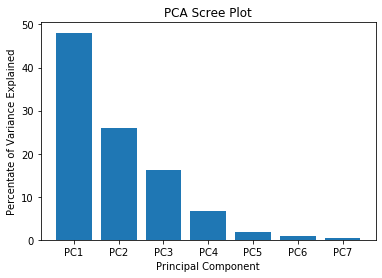

In [759]:
# PCA
x = StandardScaler().fit_transform(feature_matrix[0][['OutOfRange', 'meanOutOfRange', 'mk_test_trend', 'mk_test_p_value', 'mk_test_z_value', 'variance_FFT', 'MeanRange']])
pca = decomposition.PCA(n_components=7)
pca2 = pca.fit(x)
print(pca2.components_)
print(pca2.explained_variance_ratio_)
# principalComponents = pca.fit_transform(x)
principalComponents = pca2.transform(x)
columns1 = ['OutOfRange', 'meanOutOfRange', 'mk_test_trend', 'mk_test_p_value', 'mk_test_z_value', 'variance_FFT', 'MeanRange']
principalDataframe = pd.DataFrame(data=principalComponents, columns=['OutOfRange', 'meanOutOfRange', 'mk_test_trend', 'mk_test_p_value', 'mk_test_z_value', 'variance_FFT', 'MeanRange'])
#targetDataframe = df[['target']]

#newDataframe = pd.concat([principalDataframe, targetDataframe],axis = 1)
percent_variance = np.round(pca.explained_variance_ratio_ * 100, decimals=2)
columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7']
plt.bar(x=range(1, 8), height=percent_variance, tick_label=columns)
plt.ylabel('Percentate of Variance Explained')
plt.xlabel('Principal Component')
plt.title('PCA Scree Plot')
plt.show()

In [764]:
for i in range(1,numFiles+1):
    feature_matrix[i-1].to_csv("dm_proj1_data/intermediate_files/feature_matrix{}.csv".format(i))
#     cgm_merged.to_csv("dm_proj1_data/intermediate_files/cgm_merged_{}.csv".format(i))